In this notebook, we will be building our model for the open-world experiments to binary classify by determining whether the web traffic trace corresponds to a monitored website or unmonitored website.   

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Extracting Data

To begin, we will first import the dataframes into this notebook

In [2]:
with open('datasets/extracted_features.pkl', 'rb') as f:
    extracted_df = pickle.load(f)

In [3]:
extracted_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


We relabel the data such that monitored websites will be labelled as 1 and unmonitored websites will be labelled as 0

In [4]:
relabelled_df = extracted_df.copy()
relabelled_df['label'] = relabelled_df['label'].apply(lambda x: 1 if x>=0 else x)

In [5]:
relabelled_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,1,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,1,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,1,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,1,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,1,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In [6]:
X = relabelled_df.drop(columns=['label'])
y = relabelled_df['label']

# Feature Importance

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [8]:
df = pd.DataFrame(X_train)

In [9]:
df.head()

,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
1373,3378,278,3656,0.923961,0.076039,1154.342016,1598.133094,40.09,0.010966
5799,1099,69,1168,0.940925,0.059075,345.411433,595.681159,62.94,0.053887
9637,5731,332,6063,0.945242,0.054758,2115.645547,3282.496988,37.42,0.006172
16404,35,16,51,0.686275,0.313725,15.917267,26.125000,9.19,0.180196
7660,2310,307,2617,0.882690,0.117310,820.464988,1149.498371,31.22,0.011930


In [10]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=0)
clf.fit(X_train, y_train)
feature_imp = pd.Series(clf.feature_importances_, index=df.columns).sort_values(ascending=False)

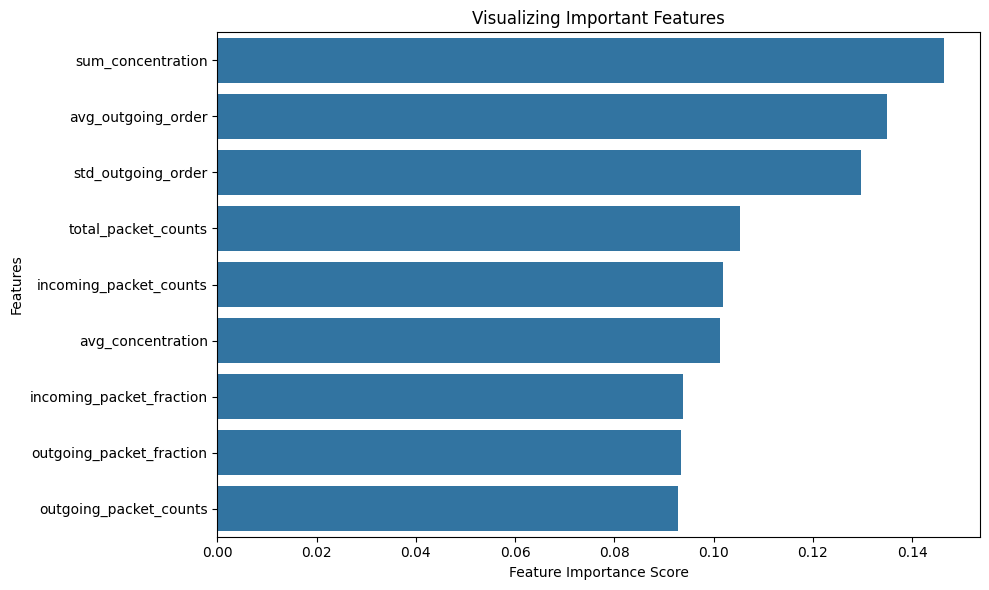

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

Recall the extracted features:
> **Feature Group 1: Traffic Volume (Absolute)**  
> - Feature 1: Number of incoming packets  
> - Feature 2: Number of outgoing packets  
> - Feature 3: Total number of packets  
> 
> **Feature Group 2: Traffic Volume (Fraction)**
> - Feature 1: Number of incoming packets as a fraction of the total number of packets  
> - Feature 2: Number of outgoing packets as a fraction of the total number of packets 
> 
> **Feature Group 3: Traffic Ordering List**
> - Feature 6: Standard deviation of the outgoing packets ordering list  
> - Feature 7: Average of the outgoing packets ordering list  
> 
> **Feature Group 4: Traffic concentration** 
> - Feature 8: Sum of all items in the alternative concentration feature list  
> - Feature 9: Average of all items in the alternative concentration feature list  

We noted that within each of the 4 feature groups, the features are likely to be highly correlated due to their similarity. Furthermore, feature groups 1 and 2 are closely related as well with 1 being an absolute measurement of traffic volume and 2 as the ratio. Hence we will be selecting 2 features from the combination of group 1 and 2, and 1 feature each from group 3 and 4.

According to our feature importance analysis, we have selected the features to be
1. Feature 1: Number of incoming packets   
2. Feature 3: Total number of packets
3. Feature 7: Average of the outgoing packets ordering list 
4. Feature 8: Sum of all items in the alternative concentration feature list  

In [12]:
X = relabelled_df[['incoming_packet_counts', 'total_packet_counts', 'avg_outgoing_order', 'sum_concentration']]
y = relabelled_df['label']

# Constructing Model

In this section, we construct an arbitrary random forest classification model using arbitrarily chosen parameters. This section aims to explore the implementation of the model. These parameters will be tuned in the next section. 

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [14]:
df = pd.DataFrame(X_train)

In [15]:
df.head()

,incoming_packet_counts,total_packet_counts,avg_outgoing_order,sum_concentration
1373,3378,3656,1598.133094,40.09
5799,1099,1168,595.681159,62.94
9637,5731,6063,3282.496988,37.42
16404,35,51,26.125000,9.19
7660,2310,2617,1149.498371,31.22


In [16]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [17]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.7284


In [18]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.64      0.52      0.58      2044
           1       0.76      0.84      0.80      3756

    accuracy                           0.73      5800
   macro avg       0.70      0.68      0.69      5800
weighted avg       0.72      0.73      0.72      5800



# Model Tuning

In [19]:
param_grid_random = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=0), 
    param_distributions=param_grid_random, 
    n_iter=50, 
    cv=5, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_random_params = random_search.best_params_
print("Best parameters from RandomizedSearchCV:", best_random_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\betti\Desktop\Bettina\School\ntu\y3s1 - exchange\Machine Learning\team project\github\neurotic_networkers\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}


In [20]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']           
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0), 
    param_grid=param_grid, 
    cv=5,  
    refit=True, 
    verbose = 3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15],
                         'n_estimators': [100, 150, 200]},
             verbose=3)

In [21]:
# print best parameters after grid search
print(grid.best_params_)

# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 150}
RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=150, random_state=0)


In [22]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8884
Test Accuracy: 0.7252


In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.65      0.47      0.55      2044
           1       0.75      0.86      0.80      3756

    accuracy                           0.73      5800
   macro avg       0.70      0.67      0.68      5800
weighted avg       0.72      0.73      0.71      5800

